In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e9
!unzip /content/playground-series-s4e9.zip
!rm /content/playground-series-s4e9.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 89% 7.00M/7.84M [00:01<00:00, 9.62MB/s]
100% 7.84M/7.84M [00:01<00:00, 6.50MB/s]
Archive:  /content/playground-series-s4e9.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install autogluon.tabular[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.5 M

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from autogluon.tabular import TabularDataset, TabularPredictor

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Fill nan with 'nan'
train.fillna('missing', inplace=True)
test.fillna('missing', inplace = True)

In [ ]:
# Lowercase everthing
train = train.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test = test.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Numeric accident
train['accident'] = train['accident'].apply(lambda x: 0 if x == 'none reported' else (0.5 if x == 'missing' else 1))
test['accident'] = test['accident'].apply(lambda x: 0 if x == 'none reported' else (0.5 if x == 'missing' else 1))

# Numeric Title
train['clean_title'] = train['clean_title'].apply(lambda x: 1 if x == 'yes' else 0)
test['clean_title'] = test['clean_title'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
def add_luxury_features(df):
    # Define luxury brands
    luxury_brands = ['mercedes-benz', 'bmw', 'audi', 'porsche', 'land', 'lexus', 'jaguar',
                     'bentley', 'maserati', 'lamborghini', 'rolls-royce', 'ferrari', 'mclaren',
                     'aston', 'maybach']

    # Create a column to indicate if the brand is a luxury brand
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if any(brand in x for brand in luxury_brands) else 0)

    return df

train = add_luxury_features(train)
test = add_luxury_features(test)

cols = ['ext_col', 'int_col','brand', 'model', 'transmission']

for i in cols:
    # Target encoding
    mean_target = train.groupby(i)['price'].mean()
    train[i] = train[i].map(mean_target)
    global_mean = train['price'].mean()
    test[i] = test[i].map(mean_target).fillna(global_mean)

In [ ]:
# Add New columns from engine
train['hp'] = train['engine'].str.extract(r'(\d+\.\d+)\s*hp')
train['l'] = train['engine'].str.extract(r'(\d+\.\d+)\s*l')
train['cylinder'] = train['engine'].str.extract(r'(\d+\s*cylinder|\bv\d+)')
train['cylinder'] = train['cylinder'].str.extract(r'(\d+)')


# Convert to appropriate types, fill missing values with NaN
train['hp'] = train['hp'].astype(float)
train['l'] = train['l'].astype(float)
train['cylinder'] = train['cylinder'].astype(float)


test['hp'] = test['engine'].str.extract(r'(\d+\.\d+)\s*hp')
test['l'] = test['engine'].str.extract(r'(\d+\.\d+)\s*l')
test['cylinder'] = test['engine'].str.extract(r'(\d+\s*cylinder|\bv\d+)')
test['cylinder'] = test['cylinder'].str.extract(r'(\d+)')


# Convert to appropriate types, fill missing values with NaN
test['hp'] = test['hp'].astype(float)
test['l'] = test['l'].astype(float)
test['cylinder'] = test['cylinder'].astype(float)

In [ ]:
# Fillna floats and drop engine
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

train.drop('engine', axis = 1, inplace = True)
test.drop('engine', axis = 1, inplace = True)

In [ ]:
def add_features(df):
    current_year = 2024

    # Calculate Vehicle Age
    df['Vehicle_Age'] = current_year - df['model_year']

    # Calculate Mileage per Year
    epsilon = 1e-6  # Small value to avoid division by zero
    df['Mileage_per_Year'] = df['milage'] / (df['Vehicle_Age'] + epsilon)

    # Calculate the mean mileage by Vehicle Age
    df['milage_with_age'] = df.groupby('Vehicle_Age')['milage'].transform('mean')

    # Calculate the mean Mileage per Year by Vehicle Age
    df['Mileage_per_Year_with_age'] = df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')

    # Calculate Power to Weight Ratio
    df['Power_to_Weight_Ratio'] = df['hp'] / (df['l']+ epsilon)

    return df

train = add_features(train)
test = add_features(test)

# Fillna floats and drop engine
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [ ]:
# Encode Fuel Type
combined_data = pd.concat([train, test], axis=0)

combined_encoded = pd.get_dummies(combined_data, columns=['fuel_type'], drop_first=False)

train = combined_encoded.iloc[:len(train), :]
test= combined_encoded.iloc[len(train):, :]
test = test.drop('price', axis = 1)

## Eda

is luxury, <br>
 df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size'], <br>
 luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land',
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini',
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')

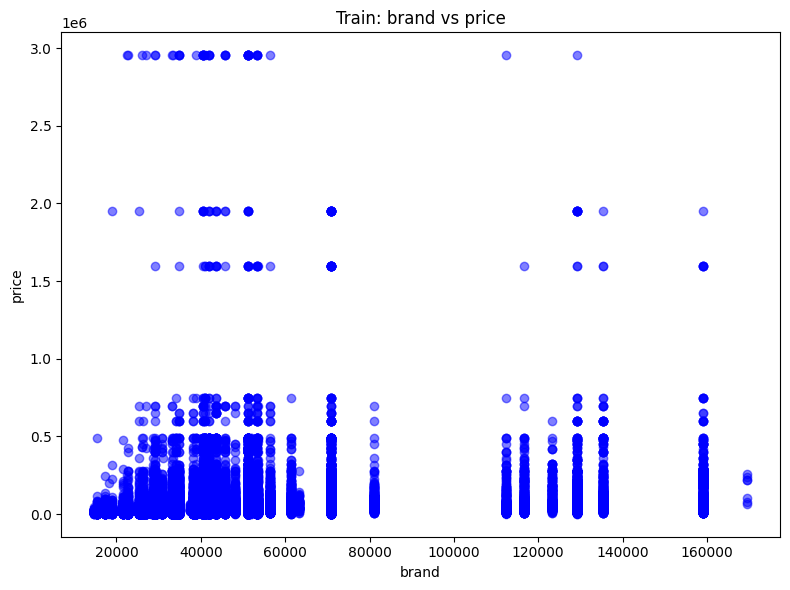

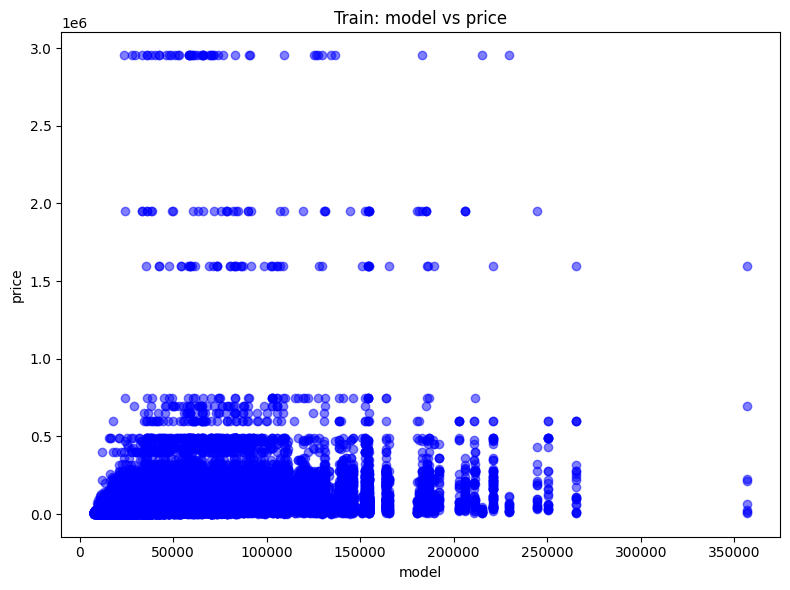

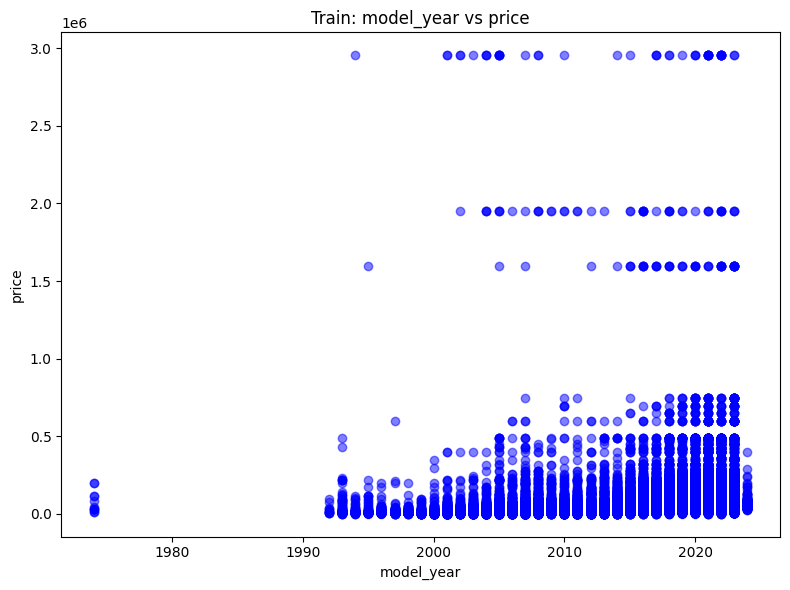

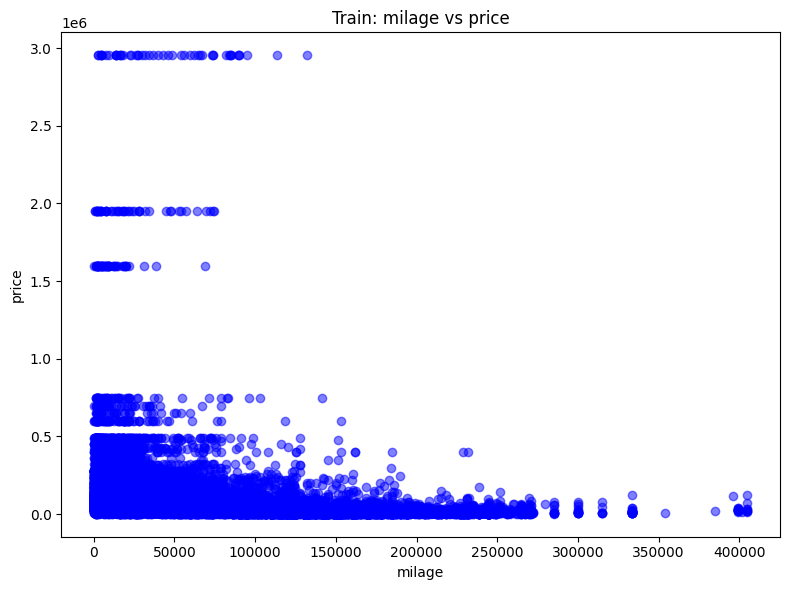

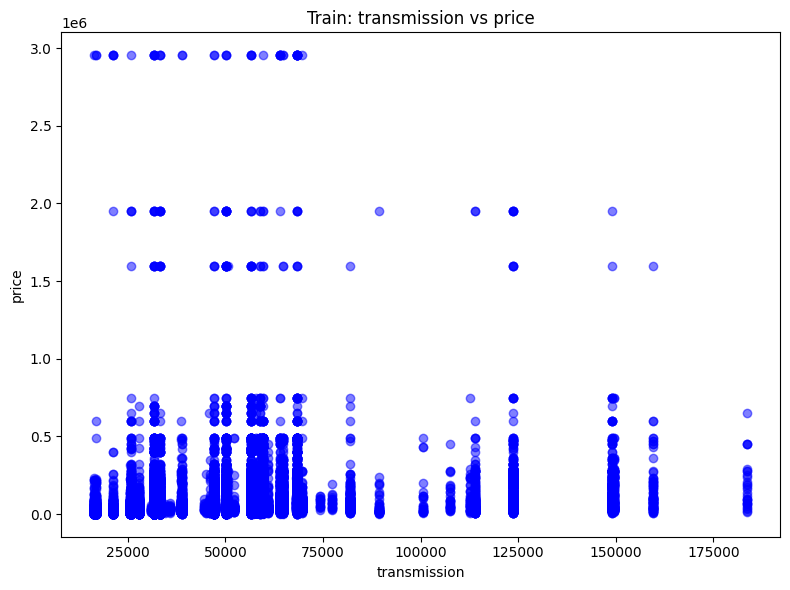

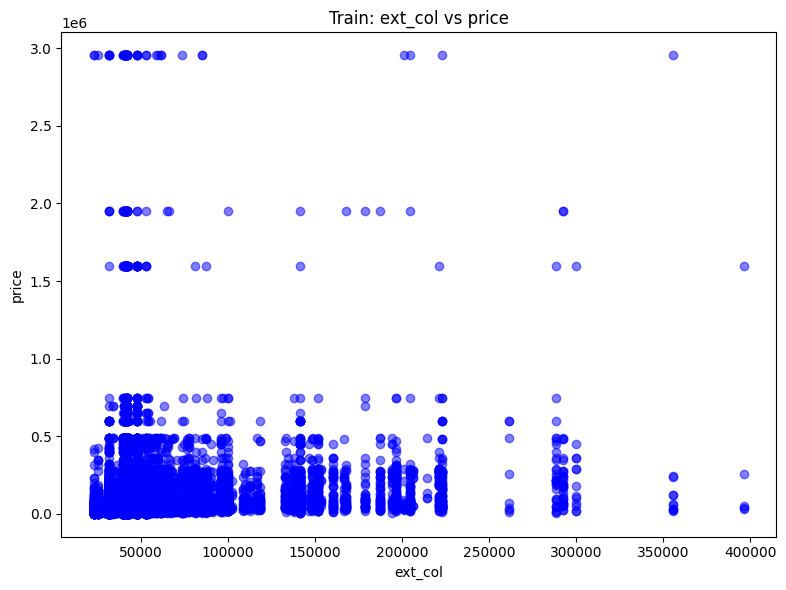

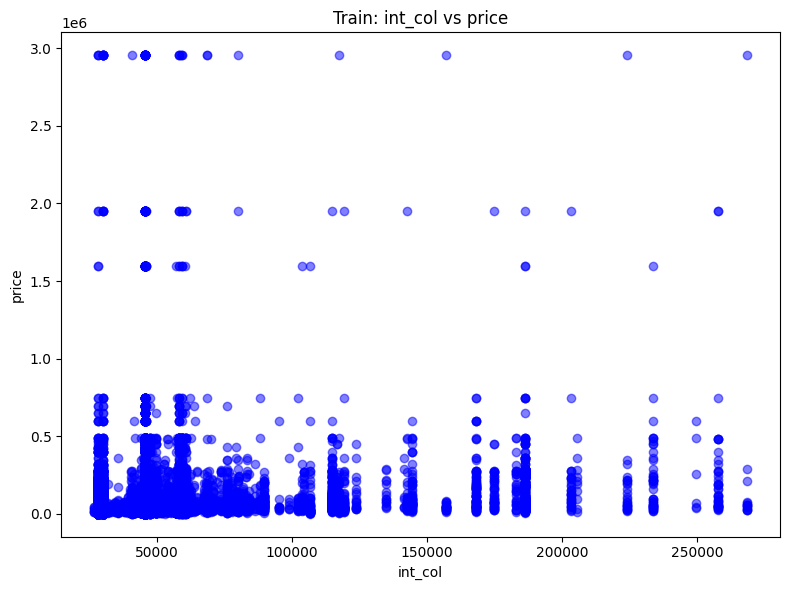

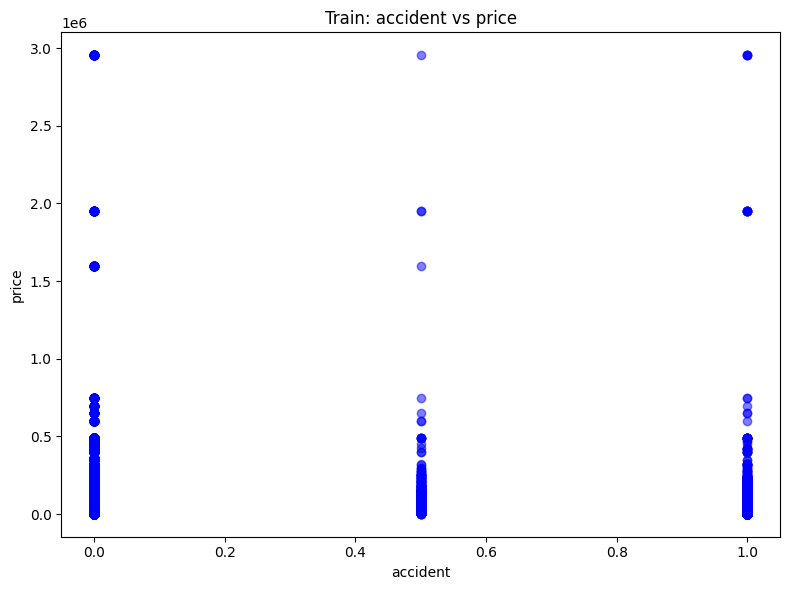

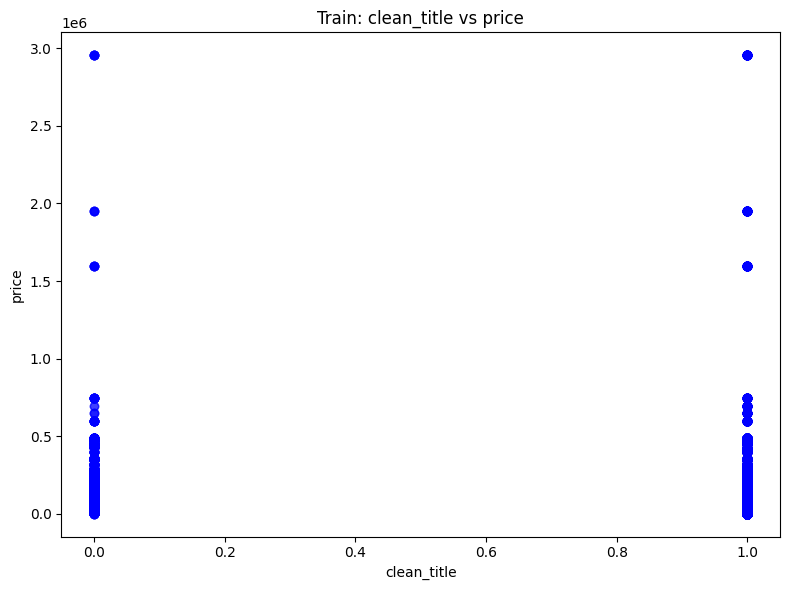

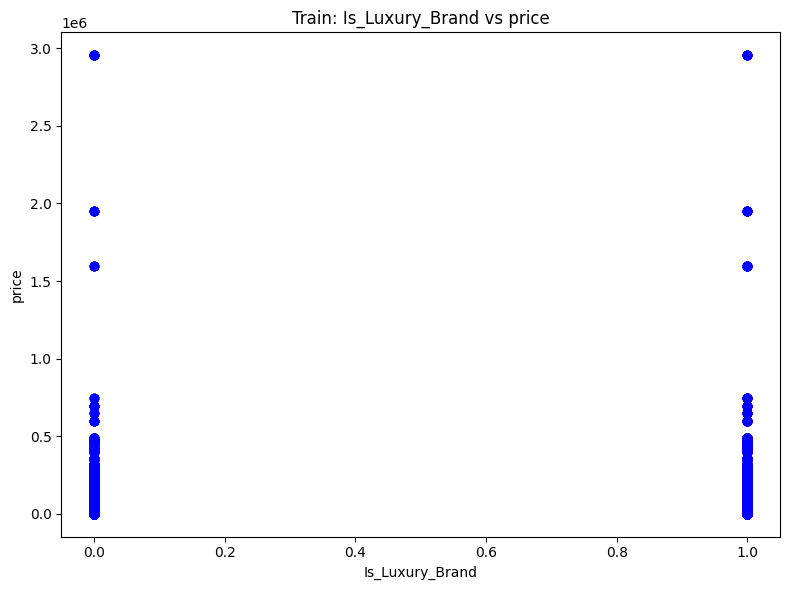

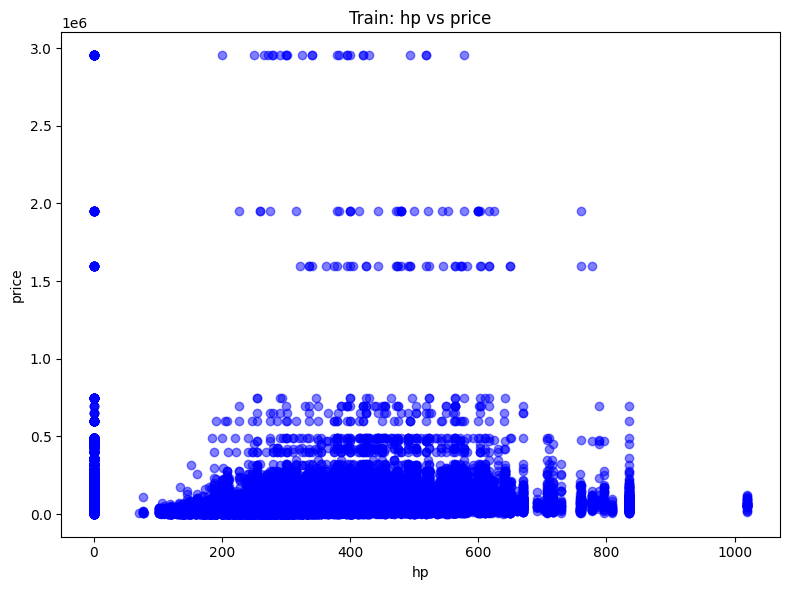

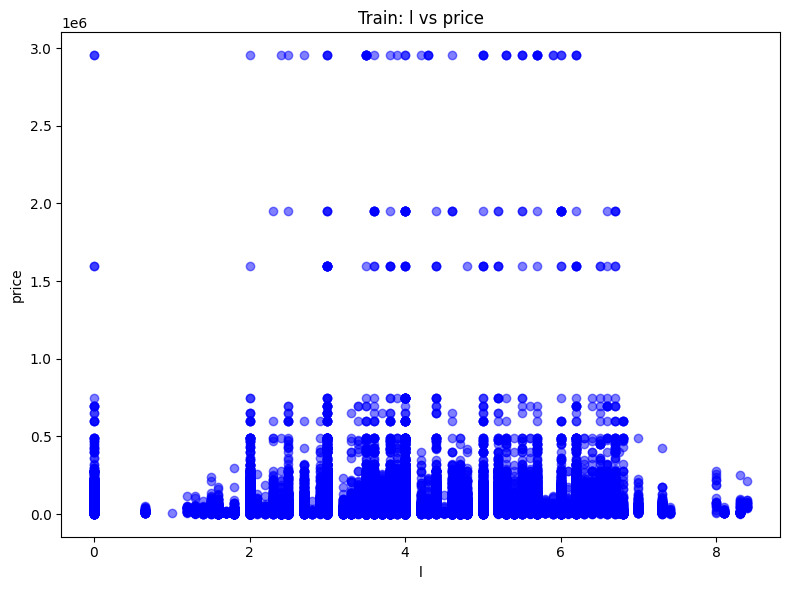

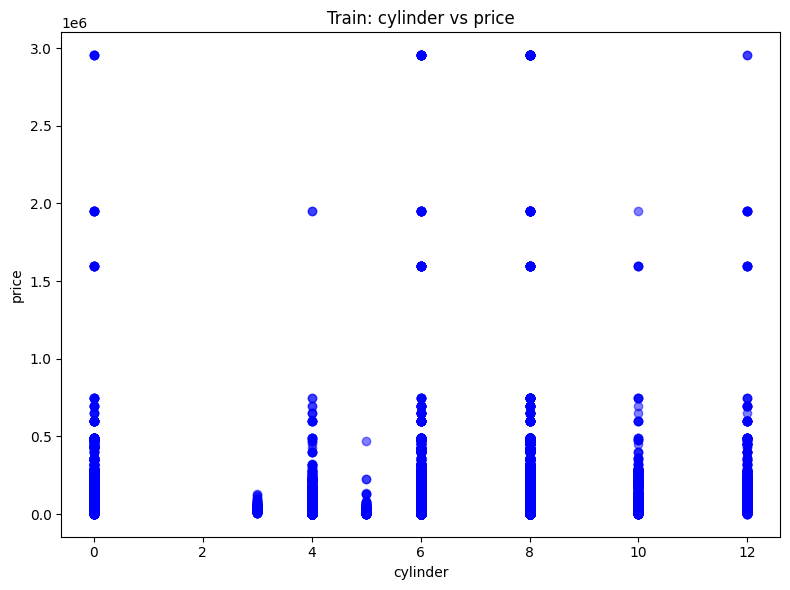

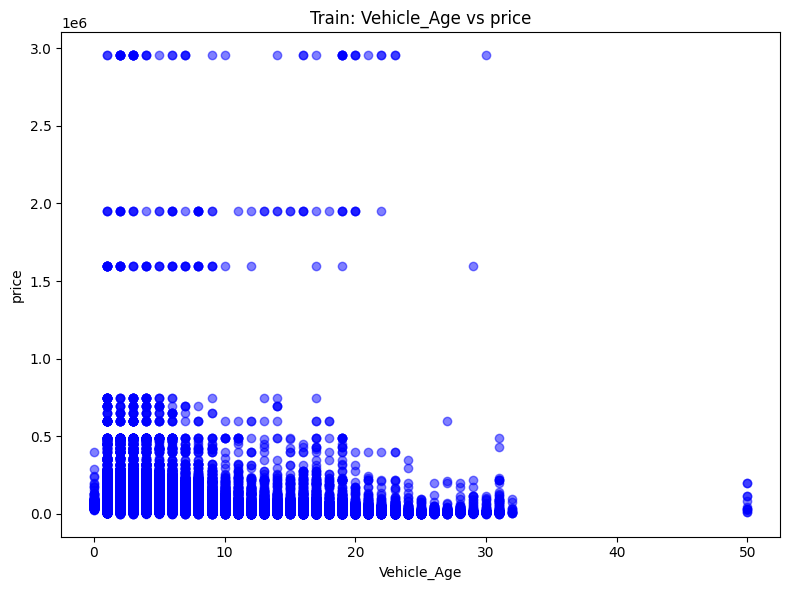

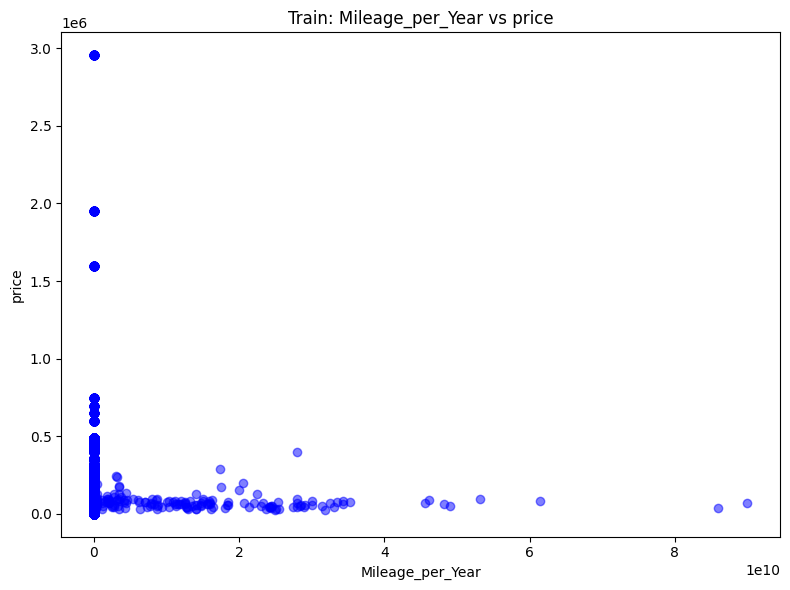

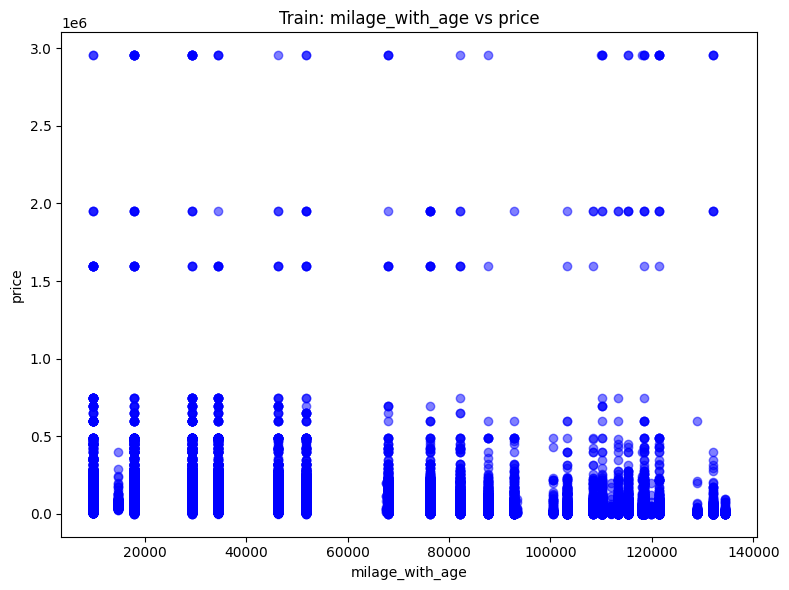

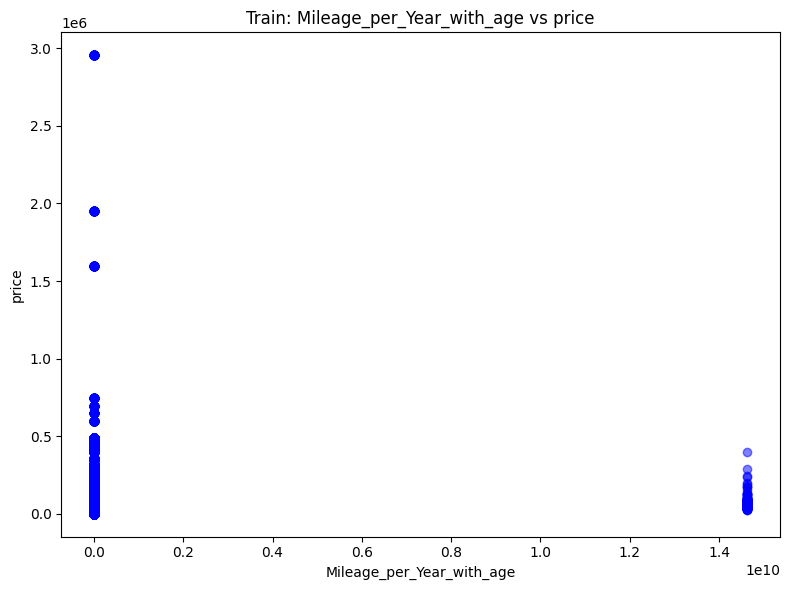

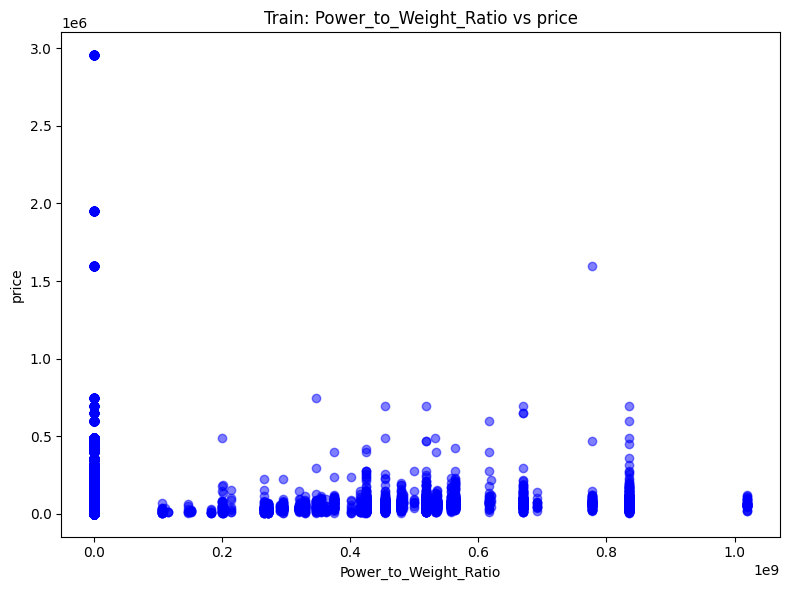

In [ ]:
# Separate numeric and object columns
numeric_cols = train.select_dtypes(include=['number']).columns
object_cols = train.select_dtypes(include=['object']).columns

# Remove target column 'price' from numeric_cols if it exists
target_col = 'price'
numeric_cols = numeric_cols.drop(target_col) if target_col in numeric_cols else numeric_cols

# Scatter plots for numeric columns against the target 'price' (train only)
for col in numeric_cols:
    plt.figure(figsize=(8, 6))

    # Scatter plot for train data
    plt.scatter(train[col], train[target_col], alpha=0.5, c='b')
    plt.title(f"Train: {col} vs {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)

    plt.tight_layout()
    plt.show()

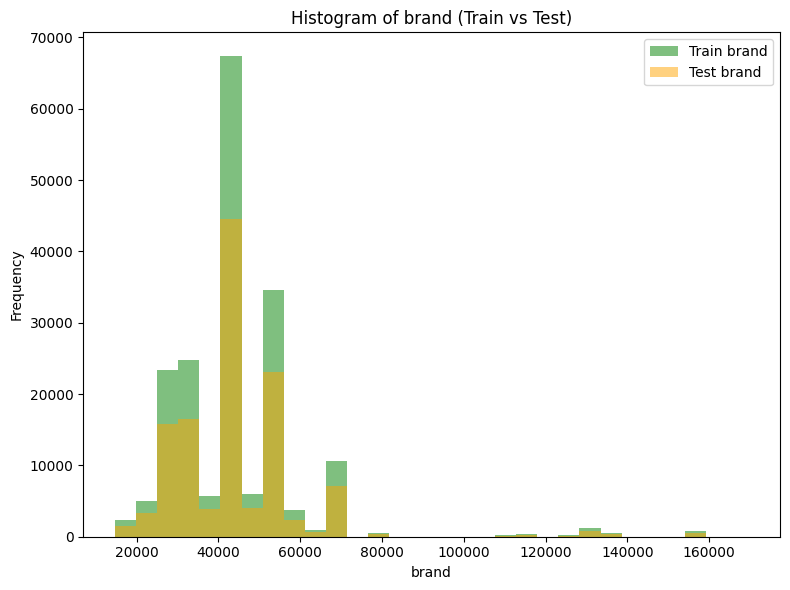

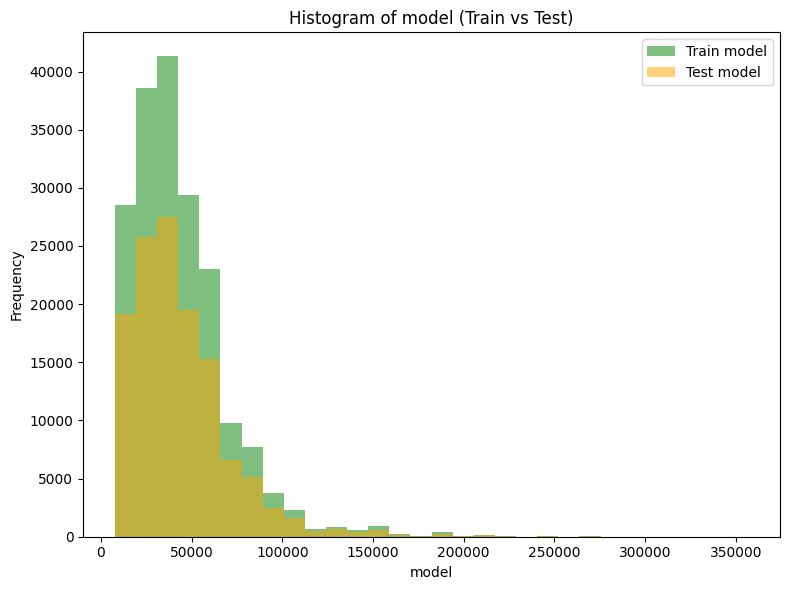

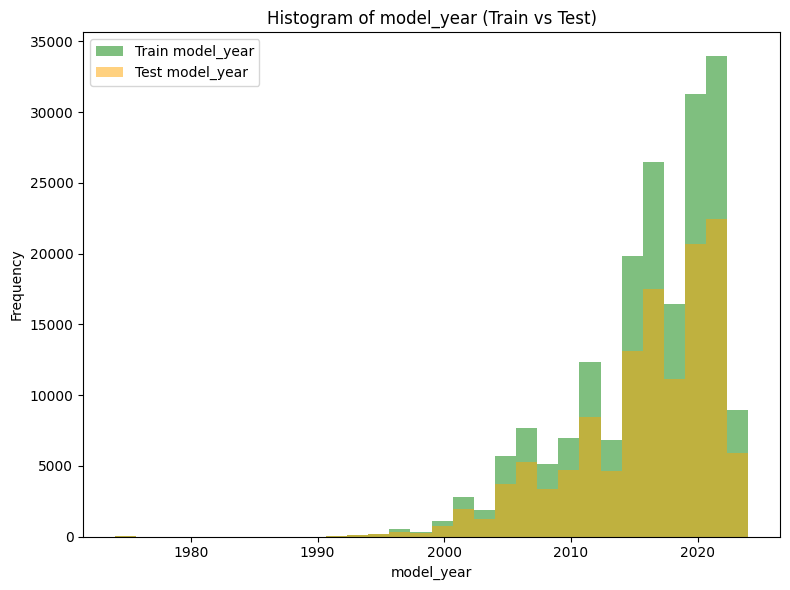

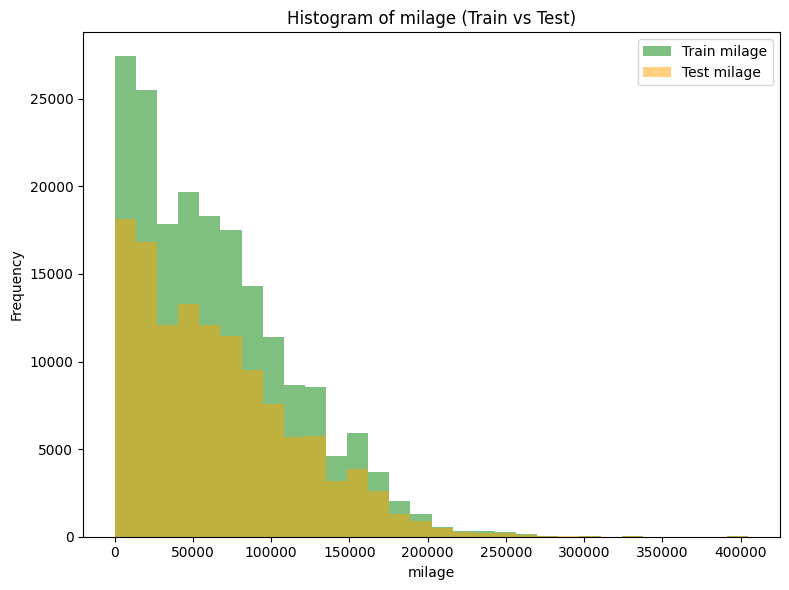

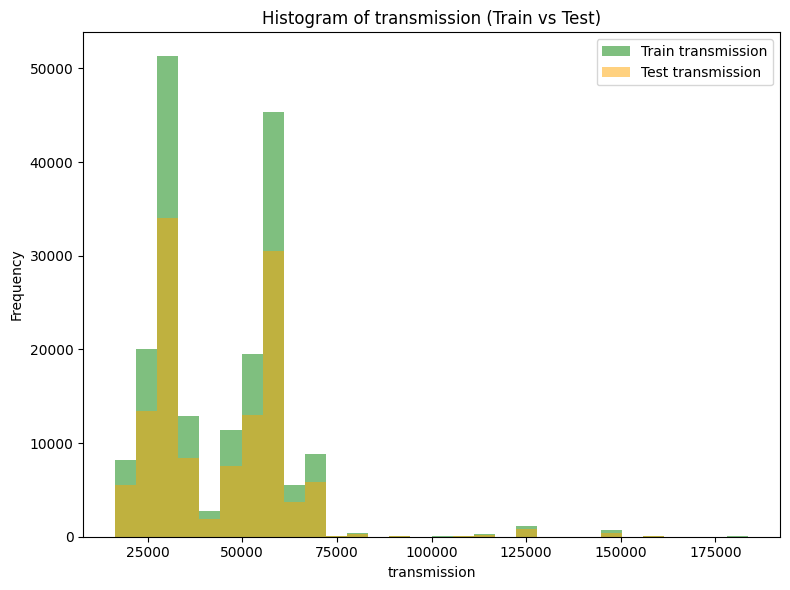

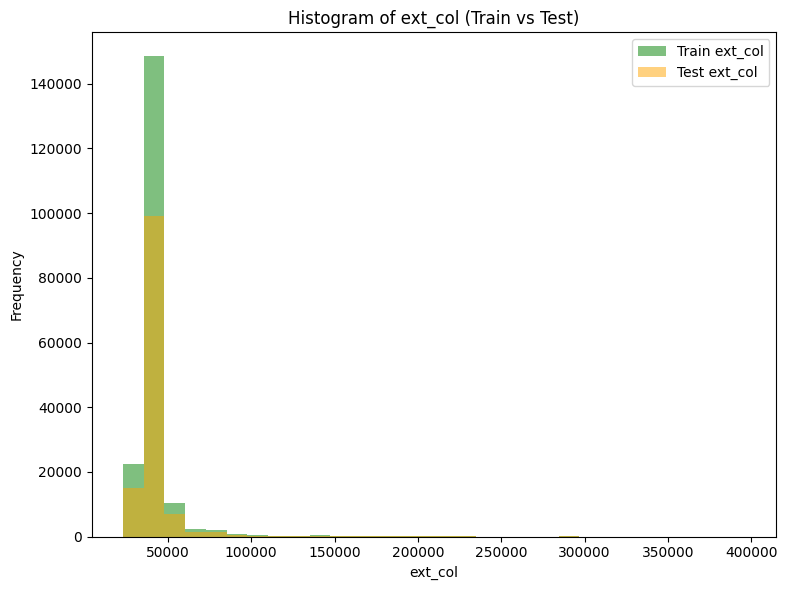

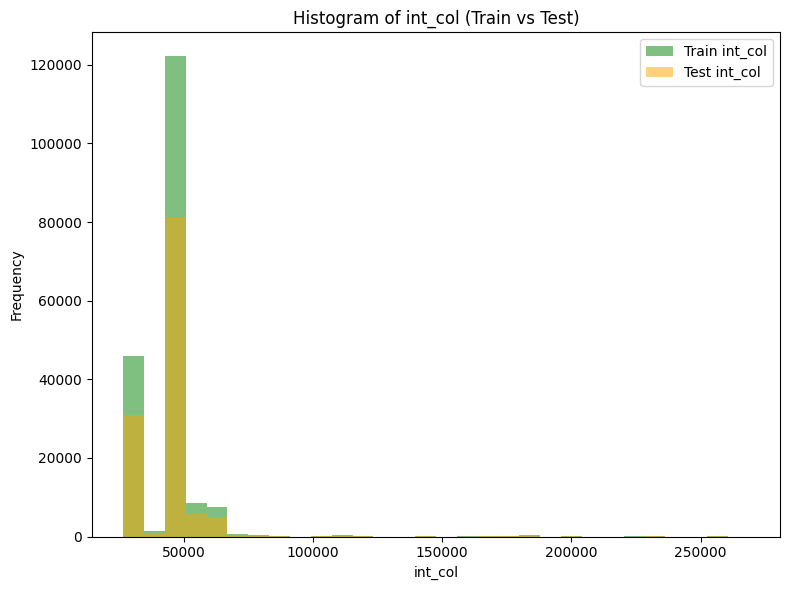

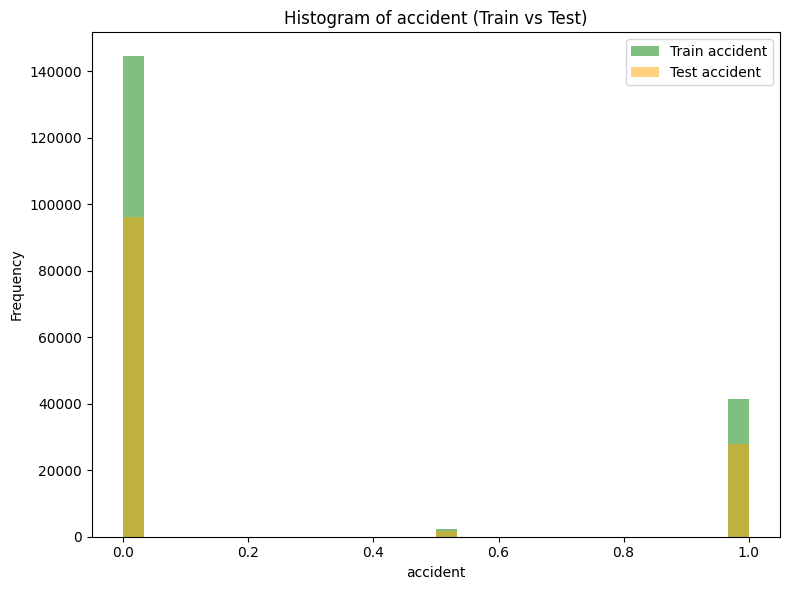

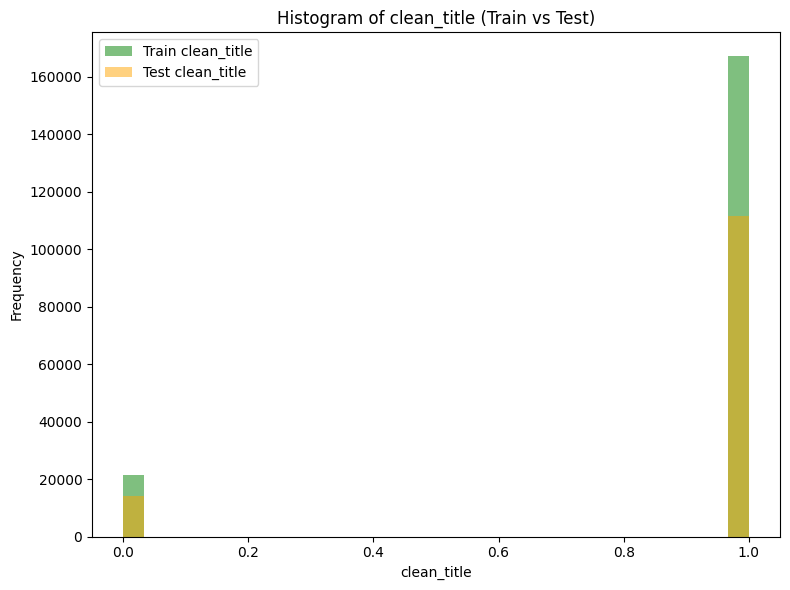

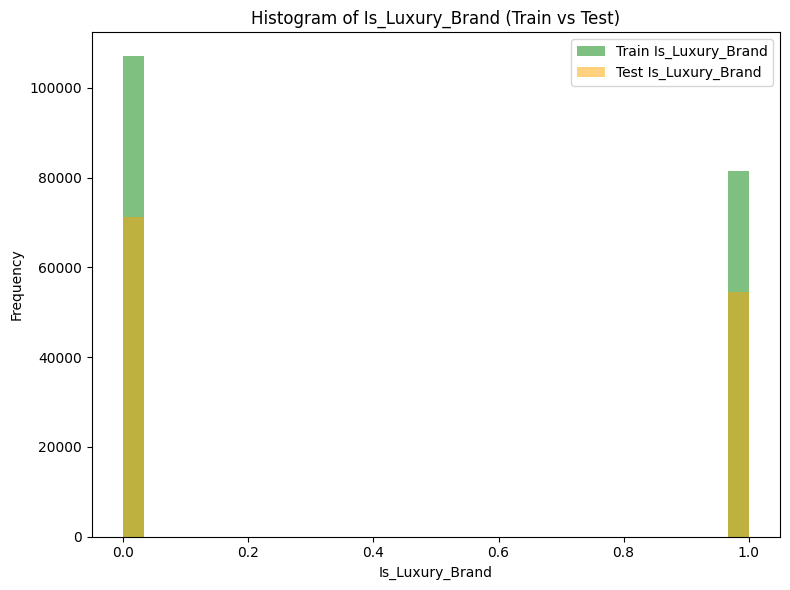

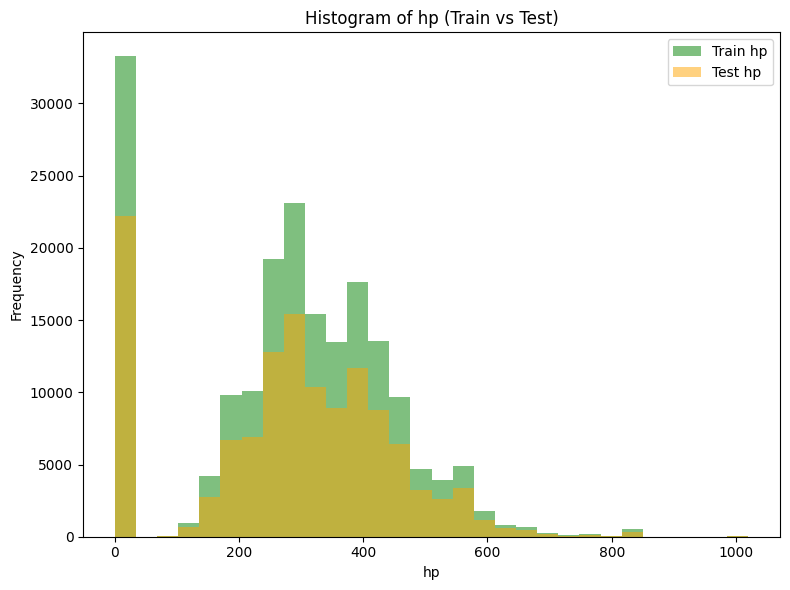

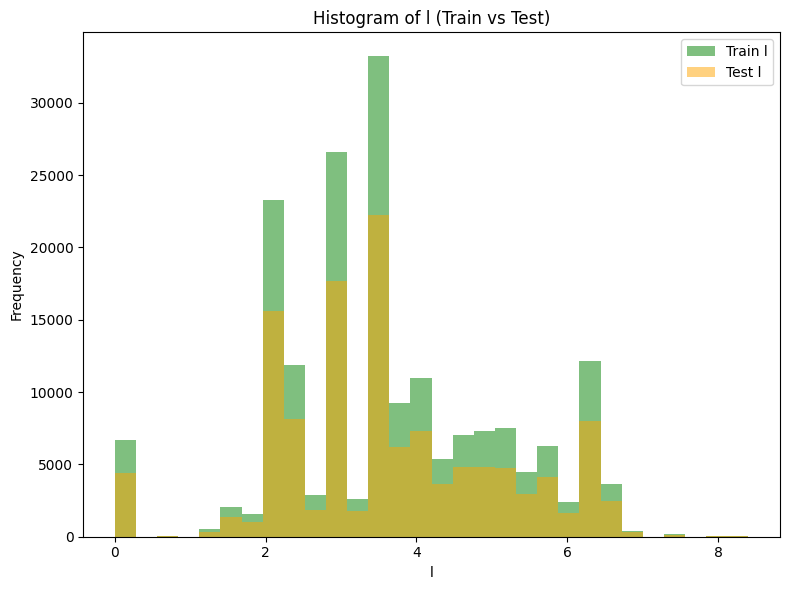

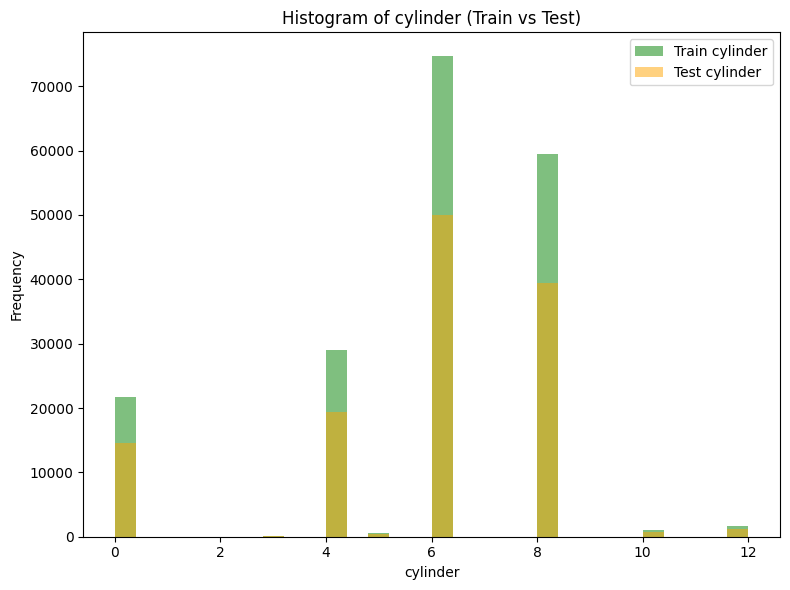

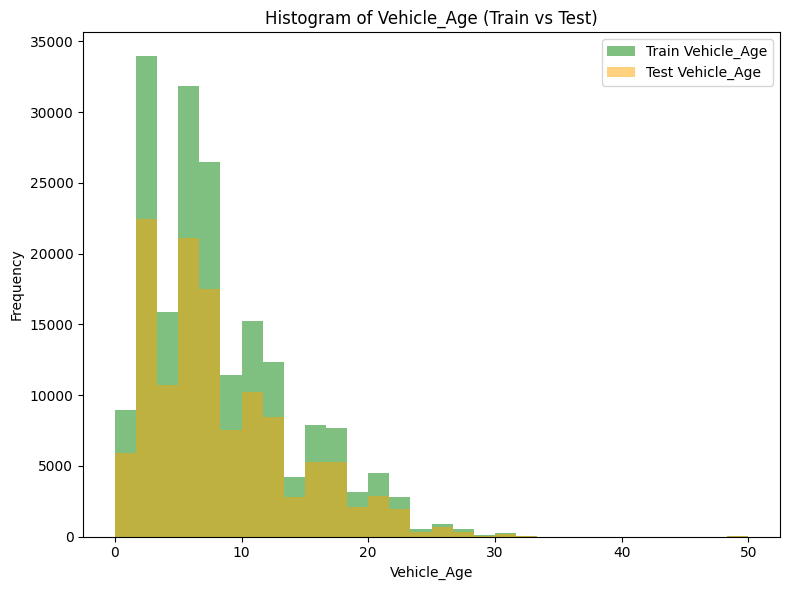

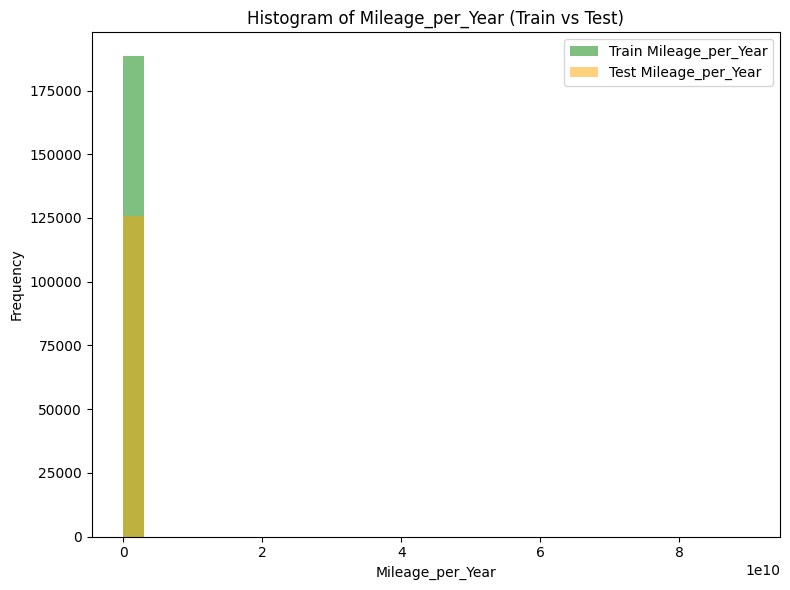

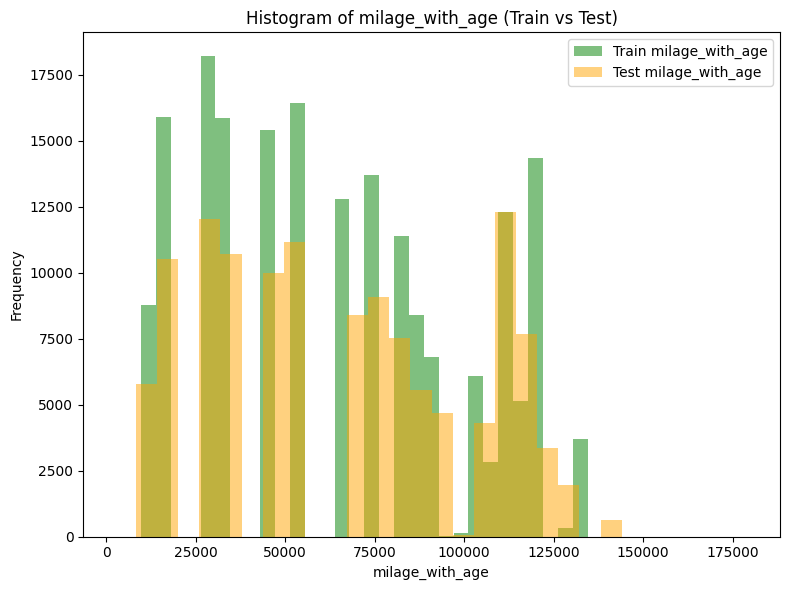

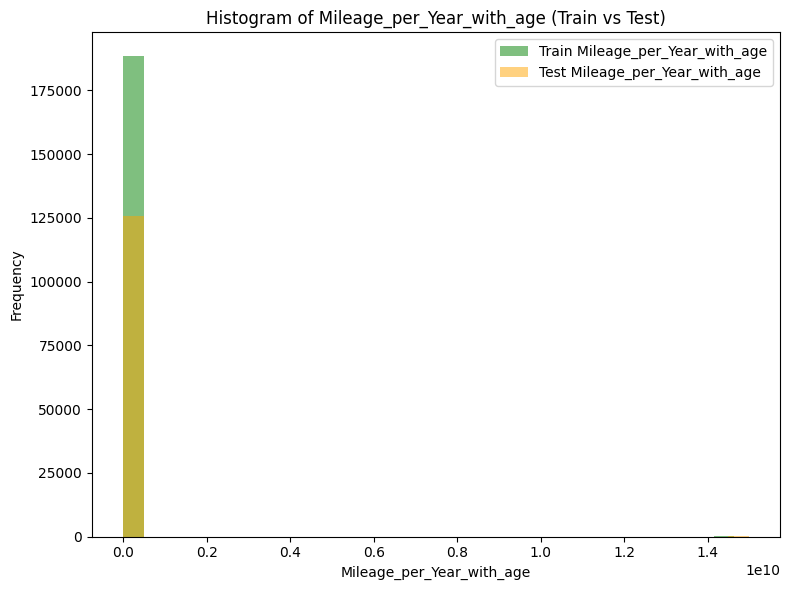

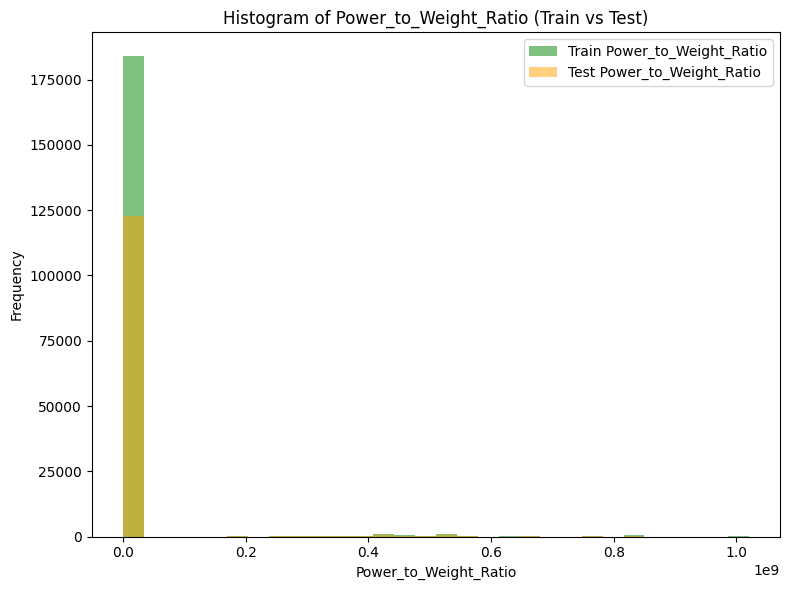

In [ ]:
# Histograms for numeric columns (train and test on the same plot)
for col in numeric_cols:
    plt.figure(figsize=(8, 6))

    # Histogram for train data
    plt.hist(train[col], bins=30, color='green', label=f'Train {col}', alpha=0.5)

    # Histogram for test data
    plt.hist(test[col], bins=30, color='orange', label=f'Test {col}', alpha=0.5)

    plt.title(f"Histogram of {col} (Train vs Test)")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

## AutoML
60041.37424432074

In [ ]:
label = 'price'
metric = 'rmse'
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train,auto_stack=True, time_limit=time_limit, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240925_232759"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.51 GB / 12.67 GB (82.9%)
Disk Space Avail:   62.28 GB / 107.72 GB (57.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be

In [ ]:
predictor.leaderboard(train, extra_metrics=[ 'mse', 'rmse', 'mae', 'r2'])

,model,score_test,mean_squared_error,root_mean_squared_error,mean_absolute_error,r2,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-4955.853262,-2.456048e+07,-4955.853262,-59.784270,0.996047,-79675.642401,root_mean_squared_error,220.776207,219.869341,0.122092,220.776207,219.869341,0.122092,1,True,2
1,WeightedEnsemble_L2,-60041.374244,-3.604967e+09,-60041.374244,-17034.850779,0.419722,-78101.585633,root_mean_squared_error,444.557386,450.234723,0.383913,0.006329,0.003225,0.123673,2,True,3
2,KNeighborsUnif_BAG_L1,-64017.498305,-4.098240e+09,-64017.498305,-18167.258001,0.340322,-78109.109524,root_mean_squared_error,223.774851,230.362157,0.138148,223.774851,230.362157,0.138148,1,True,1


In [ ]:
predictor.model_best

'WeightedEnsemble_L2'

In [ ]:
predictor.feature_importance(train)

Computing feature importance via permutation shuffling for 26 features using 5000 rows with 5 shuffle sets...
	1497.2s	= Expected runtime (299.44s per shuffle set)
	1592.17s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
model,24415.083665,6358.308478,0.000505,5,37506.928703,11323.238627
milage,20571.003134,4370.612250,0.000230,5,29570.154166,11571.852102
milage_with_age,20098.763320,2928.972833,0.000053,5,26129.558866,14067.967775
brand,12763.245683,2953.657318,0.000321,5,18844.866925,6681.624441
transmission,12526.801058,2388.920264,0.000151,5,17445.620899,7607.981216
int_col,10081.620510,5648.229733,0.008124,5,21711.403597,-1548.162577
ext_col,7668.488995,3481.437432,0.003950,5,14836.816787,500.161204
Mileage_per_Year,3796.915804,1053.503434,0.000644,5,5966.093936,1627.737672
Mileage_per_Year_with_age,2006.232343,902.481975,0.003824,5,3864.455204,148.009482
hp,656.547983,128.712745,0.000169,5,921.569303,391.526663


In [ ]:
y_pred = predictor.predict(test)

In [ ]:
# sub['price'] = y_pred
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

## Preds Analysis

In [ ]:
train_preds = predictor.predict(train)
rmse = np.sqrt(mean_squared_error(train['price'], train_preds))
print("RMSE:", rmse)

RMSE: 60041.37424432074


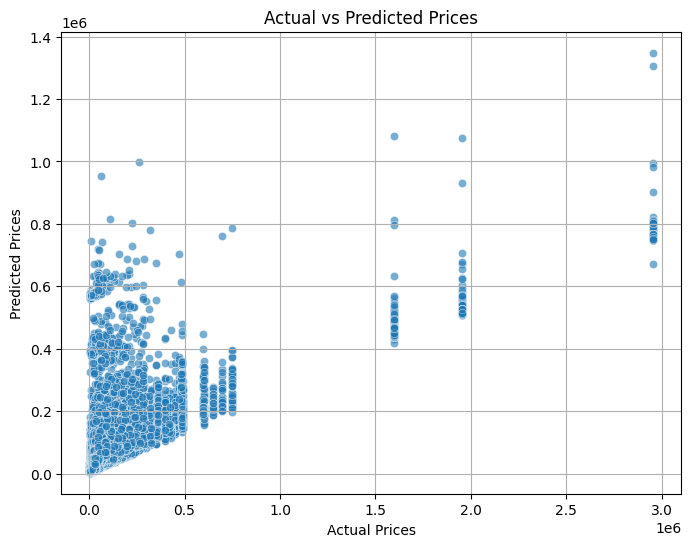

In [ ]:
# Assuming train['price'] contains the actual prices and train_preds contains the predictions
plt.figure(figsize=(8, 6))

# Create the scatter plot
plt.scatter(train['price'], train_preds, alpha=0.6, edgecolors='w', linewidth=0.5)

# Add labels and title
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Display the plot
plt.grid(True)
plt.show()